# 3 - 3D Modeling with GemPy

In [22]:
import sys
import numpy as np
# These two lines are necessary only if gempy is not installed
sys.path.append("../../gempy/")
sys.path.append("../gempy/")

# Importing gempy
import gempy as gp
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [3]:
geo_data=gp.create_data(extent=[612000, 622000, 2472000, 2480000, -1000, 1000], 
                        resolution=[50, 50, 50], 
                        path_f = "../data/gempy_foliations.csv",
                        path_i = "../data/gempy_interfaces.csv")

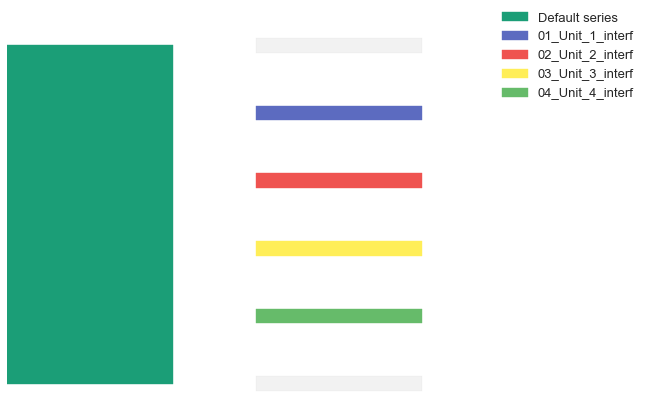

In [15]:
gp.set_series(geo_data, {"Default series": np.unique(geo_data.interfaces["formation"].values)},
             order_formations = np.unique(geo_data.interfaces["formation"].values))

gp.set_order_formations(geo_data, np.unique(geo_data.interfaces["formation"].values))

## 3.2 - Data visualization

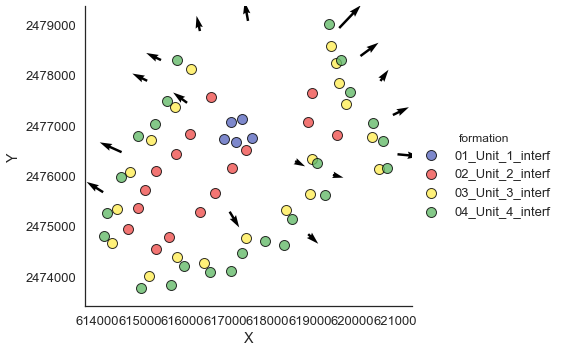

In [16]:
gp.plot_data(geo_data, direction="z")

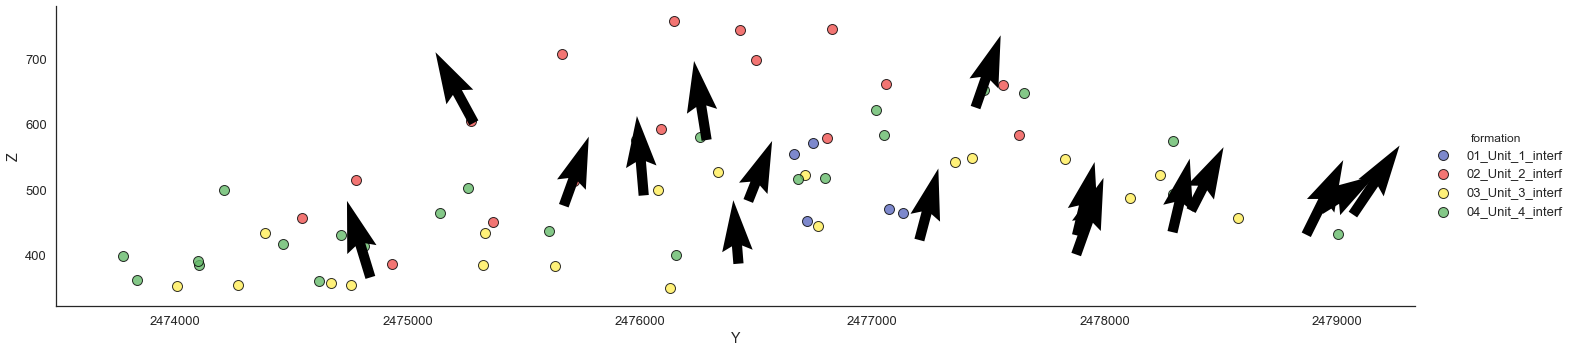

In [17]:
gp.plot_data(geo_data, direction="x")

## 3.3 - Computing the 3D Model

In [18]:
interp_data = gp.InterpolatorInput(geo_data, dtype="float32")

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


In [19]:
lith_block, fault_block = gp.compute_model(interp_data)

## 3.4 - Model visualization

### 3.4.1 - 2D Sections

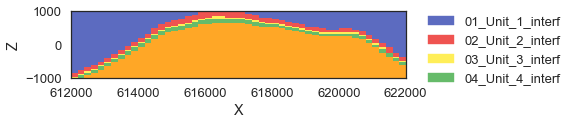

In [26]:
gp.plot_section(geo_data, lith_block[0], 25, direction='y')

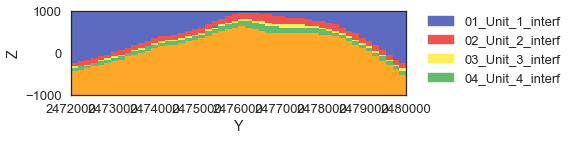

In [27]:
gp.plot_section(geo_data, lith_block[0], 25, direction='x')

### 3.4.2 - Pseudo-3D surfaces

In [77]:
v_l, s_l = gp.get_surfaces(interp_data, potential_lith=lith_block[1], step_size=2)

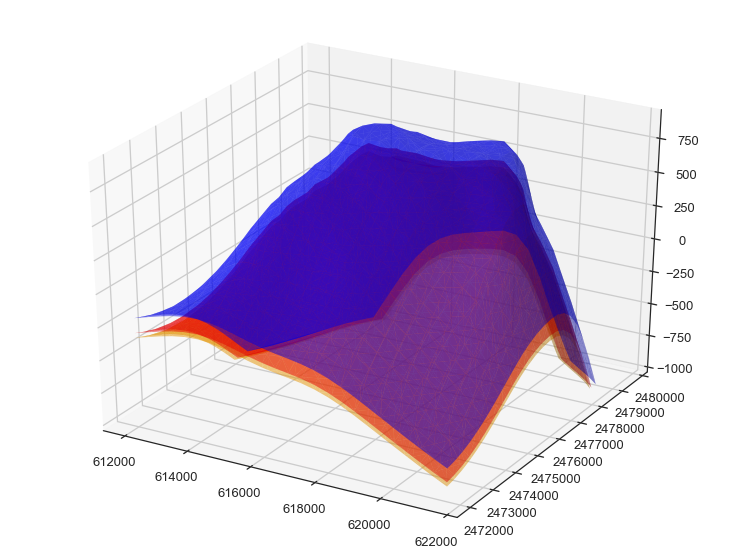

In [92]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')

cs = ["blue", "red", "orange"]

for i in range(3):
    surf = ax.plot_trisurf(v_l[i][:,0], v_l[i][:,1], v_l[i][:,2], 
                           color=cs[i], shade=True, linewidth=0, alpha=0.5)